# Ordering

**Issue:** In the `QCD` nb, I saw that the massplane looks _super_ wonky when we assign the pair based on the resonance masses.

**Plan:** See if we can use the resonance $p_T$s and the signal hypotheses to do better!

In [74]:
import h5py
import awkward as ak
import uproot
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from itertools import product

from coffea.nanoevents.methods import vector
ak.behavior.update(vector.behavior)

import os
os.sys.path.append('../RRevolution/code/')
os.sys.path.append('../PyATLASstyle/')

from glob import glob
import pandas as pd

from analysis import processDf
from trigger import trigger_lut, bucket_config_generator, assign_bucket, get_nr_bucket
from utils import L, mcToYr, physToDSID

import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%%bash
ls ../RRevolution/code/

analysis.py
dask-worker-space
getHashes.C
getMassplanes.py
__init__.py
JVT
log_files
make_tsv_file.py
mdr.py
pairing_mva.py
preprocessUtils.py
processMNTs.py
__pycache__
steerEasyJet.py
steerGetMassplanes.py
steerProds.py
trigger.py
truth.py
utils.py
vbf.py


bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by bash)


In [75]:
fDir = '../data/signals'
mX = 750
rtag = 'r13145'

year = mcToYr[rtag]

first_tag = "Internal Simulation"
second_tag = r"$\sqrt{s}$ = 13 TeV, "+"X->SH->4b\n"
second_tag += f"$m_X$ = {mX} GeV" #", $m_S$ = {mS} GeV"

mS_list = [70,100,170,200,300,400,500]


In [4]:
mcToYr

{'mc20a': 2016,
 'mc20d': 2017,
 'mc20e': 2018,
 'r13167': 2016,
 'r13144': 2017,
 'r13145': 2018}

In [77]:
# Some setup
vecDict = {'pt':'pt', 'eta':'eta','phi':'phi', 'mass':'m'}

tkeys = [f'truth_H{i}_{v}' for i, v in product([1,2],vecDict.values())]
tkeys += [f'truth_bb_fromH{i}_{v}' for i, v in product([1,2],vecDict.values())]
taliases = { k[6:] : f'{k}/1000' if ((k[-2:] == 'pt') or (k[-1] == 'm')) 
            else k for k in tkeys}

tname = 'AnalysisMiniTree'

In [78]:
tarrs = []
bs = []

for i, mS in enumerate(mS_list):
    
    dsid = physToDSID[f'X{mX}_S{mS}']
    
    sig_name  = f'{fDir}/user.dabattul.ntup_SH4b_AF3_24022023.{dsid}.Py8EG_A14NNPDF23LO_XHS_X{mX}_S{mS}_4b.e8448_a899_{rtag}_p5511_TREE/'
    sig_name += 'user.dabattul.*._00*.output-hh4b.root'
    
    tarr = uproot.concatenate(f'{sig_name}:{tname}',taliases.keys(),aliases=taliases)
    tarrs.append(tarr)
     
    H_bs = ak.zip( { k: tarr[f'bb_fromH1_{v}'] for k,v in vecDict.items() }, 
               with_name="PtEtaPhiMLorentzVector", behavior=vector.behavior )
    S_bs = ak.zip( { k: tarr[f'bb_fromH2_{v}'] for k,v in vecDict.items() }, 
                   with_name="PtEtaPhiMLorentzVector", behavior=vector.behavior )

    b4 = ak.concatenate([H_bs,S_bs],1)
    bs.append( b4 )
    

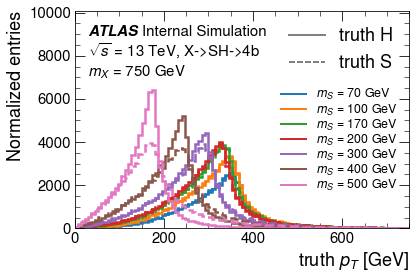

In [73]:
lw=2.5

for i, mS, tarr in zip(range(len(mS_list)),mS_list, tarrs):
    
    color = f'C{i}'
    kwargs = {'bins':100, 'range':(0,750), 'histtype':'step','lw':lw,'color':color}
    plt.hist(tarr['H1_pt'].to_numpy(), ls='-',**kwargs)
    plt.hist(tarr['H2_pt'].to_numpy(),ls='--',**kwargs)
        
for c,ls in zip(['H','S'],['-','--']):
    plt.plot([],[],label=f'truth {c}',ls=ls,color='grey')
    
plt.legend(fontsize=18)
    
# Add the 2nd legend
fig = plt.gcf()
ax = plt.gca()
lines = []
labels = []
for i, mS in zip(range(len(mS_list)),mS_list):
    
    lines += plt.plot([],[],color=f'C{i}')
    labels.append(f'$m_S$ = {mS} GeV')
    
leg = Legend(ax, lines,labels,loc='upper right',
             bbox_to_anchor=(1,.7),labelspacing=0,fontsize='small')

ax.add_artist(leg)
 
    
'''
Add the atlas tag
'''
pas.makeATLAStag(ax, fig, first_tag=first_tag, 
                 second_tag=second_tag, line_spacing=1)
    
plt.xlabel('truth $p_T$ [GeV]',fontsize=18,loc='right')
plt.ylabel('Normalized entries',fontsize=18,loc='top')
plt.xlim(kwargs['range'])
_,ymax = plt.ylim()
plt.ylim(0,1.5*ymax)

plt.savefig(f'figures/truth_pt_mX{mX}.pdf',bbox_inches='tight')
    

**Observation 1:** As the scalar $S$ gets _heavier_ the $p_T$ for the Higgs _and_ the S go down. 
- Less kinetic energy left over to boost the resonances.

**Observation 2:** The higher mass scalars seem to have _more_ kinetic energy.
- This is opposite to my intuition though... interesting.

Alright, this doesn't seem _crazy_ promising... but I'll try to run through / make plots for the rest of my idea and then go from there?

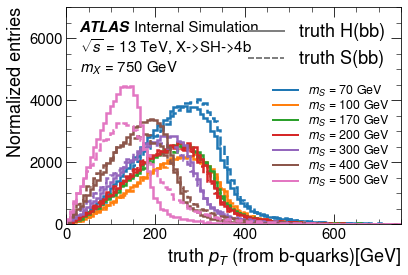

In [80]:
lw=2.5

for i, mS, b4 in zip(range(len(mS_list)),mS_list, bs):
    
    
    H = b4[:,0]+b4[:,1]
    S = b4[:,2]+b4[:,3]
    
    
    color = f'C{i}'
    kwargs = {'bins':100, 'range':(0,750), 'histtype':'step','lw':lw,'color':color}
    plt.hist(H.pt.to_numpy(), ls='-',**kwargs)
    plt.hist(S.pt.to_numpy(),ls='--',**kwargs)
        
for c,ls in zip(['H','S'],['-','--']):
    plt.plot([],[],label=f'truth {c}(bb)',ls=ls,color='grey')
    
plt.legend(fontsize=18)
    
# Add the 2nd legend
fig = plt.gcf()
ax = plt.gca()
lines = []
labels = []
for i, mS in zip(range(len(mS_list)),mS_list):
    
    lines += plt.plot([],[],color=f'C{i}')
    labels.append(f'$m_S$ = {mS} GeV')
    
leg = Legend(ax, lines,labels,loc='upper right',
             bbox_to_anchor=(1,.7),labelspacing=0,fontsize='small')

ax.add_artist(leg)
 
    
'''
Add the atlas tag
'''
pas.makeATLAStag(ax, fig, first_tag=first_tag, 
                 second_tag=second_tag, line_spacing=1)
    
plt.xlabel('truth $p_T$ (from b-quarks)[GeV]',fontsize=18,loc='right')
plt.ylabel('Normalized entries',fontsize=18,loc='top')
plt.xlim(kwargs['range'])
_,ymax = plt.ylim()
plt.ylim(0,1.5*ymax)

plt.savefig(f'figures/truth_pt_bb_mX{mX}.pdf',bbox_inches='tight')
    

Hmmmmmmm.... is this just saying that the resonance mass always has bigger $p_T$ ?

- Make the ratio plot!

<ipython-input-91-b97d89426f10>:29: RuntimeWarning: divide by zero encountered in true_divide
  ax2.hist(xx, weights=h_S / h_H, **kwargs)


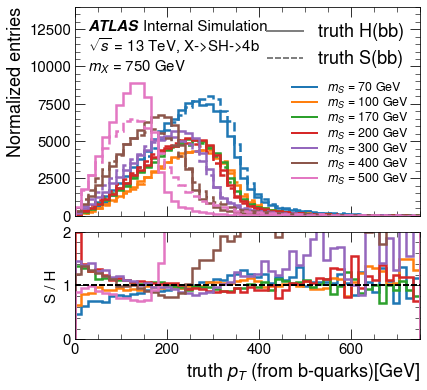

In [91]:
lw=2.5

fig, [ax,ax2] = plt.subplots(
            2,
            1,
            figsize=(6, 6),
            sharex=True,
            gridspec_kw={
                "height_ratios": [0.66, 0.34],
                "hspace": 0.1,
                "left": 0.1,
                "bottom": .11,
            },
        )

for i, mS, b4 in zip(range(len(mS_list)),mS_list, bs):
    
    
    H = b4[:,0]+b4[:,1]
    S = b4[:,2]+b4[:,3]
    
    
    color = f'C{i}'
    kwargs = {'bins':50, 'range':(0,750), 'histtype':'step','lw':lw,'color':color}
    h_H,e,_ = ax.hist(H.pt.to_numpy(), ls='-',**kwargs)
    h_S,e,_ = ax.hist(S.pt.to_numpy(),ls='--',**kwargs)
        
    xx = 0.5 * (e[1:] + e[:-1])
    ax2.hist(xx, weights=h_S / h_H, **kwargs)

ax2.plot(kwargs['range'],[1]*2,'k--')
        
for c,ls in zip(['H','S'],['-','--']):
    ax.plot([],[],label=f'truth {c}(bb)',ls=ls,color='grey')
    
ax.legend(fontsize=18)
    
# Add the 2nd legend
lines = []
labels = []
for i, mS in zip(range(len(mS_list)),mS_list):
    
    lines += ax.plot([],[],color=f'C{i}')
    labels.append(f'$m_S$ = {mS} GeV')
    
leg = Legend(ax, lines,labels,loc='upper right',
             bbox_to_anchor=(1,.7),labelspacing=0,fontsize='small')

ax.add_artist(leg)
 
    
'''
Add the atlas tag
'''
pas.makeATLAStag(ax, fig, first_tag=first_tag, 
                 second_tag=second_tag, line_spacing=1)
    
ax2.set_xlabel('truth $p_T$ (from b-quarks)[GeV]',fontsize=18,loc='right')
ax.set_ylabel('Normalized entries',fontsize=18,loc='top')
ax.set_xlim(kwargs['range'])
_,ymax = ax.get_ylim()
ax.set_ylim(0,1.5*ymax)

ax2.set_ylabel('S / H')
ax2.set_ylim(0,2)
plt.savefig(f'figures/truth_pt_bb_mX{mX}_ratio.pdf',bbox_inches='tight')
    

OK ... I don't think this is the right plot to look at. Maybe
- pT(S) - pT(H)
- pT(S) / pT(H)

But for now, I'm going to move on and look at the opening angles!!

(0.0, 3688.6499999999996)

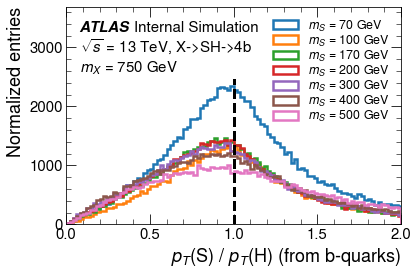

In [108]:
for i, mS, b4 in zip(range(len(mS_list)),mS_list, bs):
    
    
    H = b4[:,0]+b4[:,1]
    S = b4[:,2]+b4[:,3]
    
    color = f'C{i}'
    kwargs = {'bins':100, 'range':(0,2), 'histtype':'step','lw':lw,'color':color}
    plt.hist(S.pt.to_numpy() / H.pt.to_numpy(), label=f'$m_S$ = {mS} GeV', ls='-',**kwargs)
        
plt.legend(labelspacing=0,fontsize='small')
        
'''
Add the atlas tag
'''
fig = plt.gcf()
ax  = plt.gca() 
pas.makeATLAStag(ax, fig, first_tag=first_tag, 
                 second_tag=second_tag, line_spacing=1)
    
plt.xlabel('$p_T$(S) / $p_T$(H) (from b-quarks)',fontsize=18,loc='right')
plt.ylabel('Normalized entries',fontsize=18,loc='top')
plt.xlim(kwargs['range'])
_,ymax = plt.ylim()
plt.plot([1]*2,[0,ymax],'k--',lw=lw)

plt.ylim(0,1.5*ymax)

# plt.savefig(f'figures/truth_pt_bb_mX{mX}.pdf',bbox_inches='tight')
    

(0.0, 7150.5)

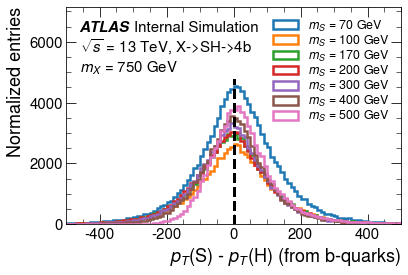

In [112]:
for i, mS, b4 in zip(range(len(mS_list)),mS_list, bs):
    
    
    H = b4[:,0]+b4[:,1]
    S = b4[:,2]+b4[:,3]
    
    color = f'C{i}'
    kwargs = {'bins':100, 'range':(-500,500), 'histtype':'step','lw':lw,'color':color}
    plt.hist(S.pt.to_numpy() - H.pt.to_numpy(), label=f'$m_S$ = {mS} GeV', ls='-',**kwargs)
        
plt.legend(labelspacing=0,fontsize='small')
        
'''
Add the atlas tag
'''
fig = plt.gcf()
ax  = plt.gca() 
pas.makeATLAStag(ax, fig, first_tag=first_tag, 
                 second_tag=second_tag, line_spacing=1)
    
plt.xlabel('$p_T$(S) - $p_T$(H) (from b-quarks)',fontsize=18,loc='right')
plt.ylabel('Normalized entries',fontsize=18,loc='top')
plt.xlim(kwargs['range'])
_,ymax = plt.ylim()
plt.plot([1]*2,[0,ymax],'k--',lw=lw)

plt.ylim(0,1.5*ymax)

# plt.savefig(f'figures/truth_pt_bb_mX{mX}.pdf',bbox_inches='tight')
    

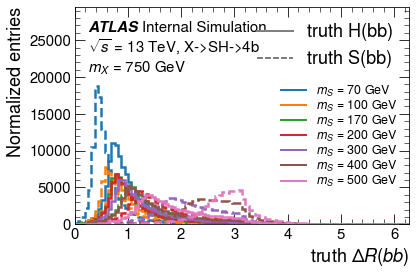

In [95]:
lw=2.5

for i, mS, b4 in zip(range(len(mS_list)),mS_list, bs):
    
    
    dR_H = b4[:,0].delta_r(b4[:,1])
    dR_S = b4[:,2].delta_r(b4[:,3])
    
    
    color = f'C{i}'
    kwargs = {'bins':100, 'range':(0,2*np.pi), 'histtype':'step','lw':lw,'color':color}
    plt.hist(dR_H.to_numpy(), ls='-',**kwargs)
    plt.hist(dR_S.to_numpy(),ls='--',**kwargs)
        
for c,ls in zip(['H','S'],['-','--']):
    plt.plot([],[],label=f'truth {c}(bb)',ls=ls,color='grey')
    
plt.legend(fontsize=18)
    
# Add the 2nd legend
fig = plt.gcf()
ax = plt.gca()
lines = []
labels = []
for i, mS in zip(range(len(mS_list)),mS_list):
    
    lines += plt.plot([],[],color=f'C{i}')
    labels.append(f'$m_S$ = {mS} GeV')
    
leg = Legend(ax, lines,labels,loc='upper right',
             bbox_to_anchor=(1,.7),labelspacing=0,fontsize='small')

ax.add_artist(leg)
 
    
'''
Add the atlas tag
'''
pas.makeATLAStag(ax, fig, first_tag=first_tag, 
                 second_tag=second_tag, line_spacing=1)
    
plt.xlabel('truth $\Delta R(bb)$',fontsize=18,loc='right')
plt.ylabel('Normalized entries',fontsize=18,loc='top')
plt.xlim(kwargs['range'])
_,ymax = plt.ylim()
plt.ylim(0,1.5*ymax)

plt.savefig(f'figures/truth_dR_bb_mX{mX}.pdf',bbox_inches='tight')
    

OK, we can't see anything from here.
- Even though the mS = 500 GeV scalar often had higher pT, the $bb$ pairs from it are more often farther apart...

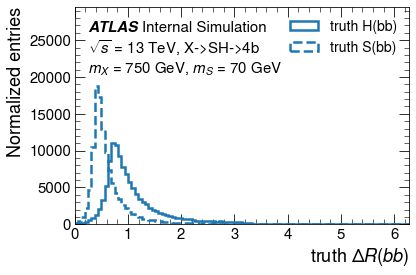

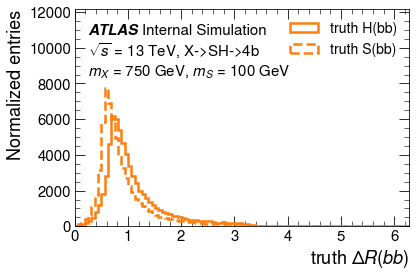

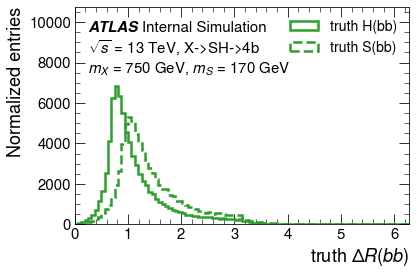

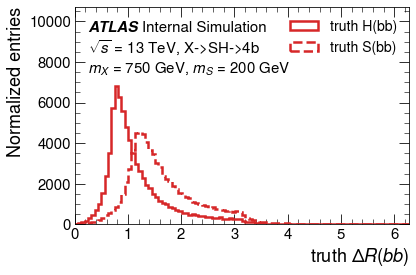

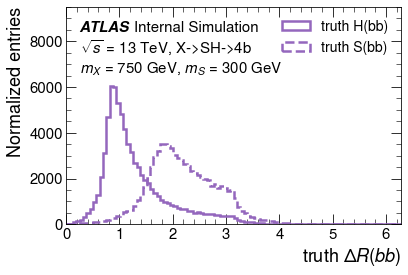

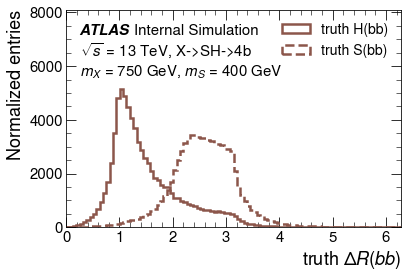

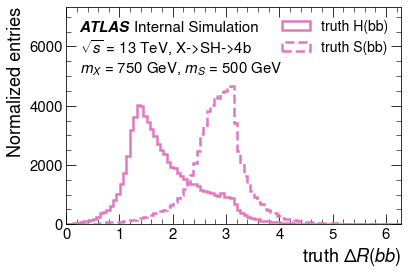

In [223]:
for i, mS, b4 in zip(range(len(mS_list)),mS_list, bs):
    
    plt.figure()
    
    dR_H = b4[:,0].delta_r(b4[:,1])
    dR_S = b4[:,2].delta_r(b4[:,3])
    
    
    color = f'C{i}'
    kwargs = {'bins':100, 'range':(0,2*np.pi), 'histtype':'step','lw':lw,'color':color}
    plt.hist(dR_H.to_numpy(), ls='-',label=f'truth H(bb)',**kwargs)
    plt.hist(dR_S.to_numpy(),ls='--',label=f'truth S(bb)',**kwargs)
        
    plt.legend()
        
    fig = plt.gcf()
    ax = plt.gca()

    '''
    Add the atlas tag
    '''
    pas.makeATLAStag(ax, fig, first_tag=first_tag, 
                     second_tag=second_tag+f', $m_S$ = {mS} GeV', line_spacing=1)

    plt.xlabel('truth $\Delta R(bb)$',fontsize=18,loc='right')
    plt.ylabel('Normalized entries',fontsize=18,loc='top')
    plt.xlim(kwargs['range'])
    _,ymax = plt.ylim()
    plt.ylim(0,1.5*ymax)

    plt.savefig(f'figures/mX750/truth_dRbb_{mS}.pdf',bbox_inches='tight')
    plt.show()
    

**Idea:** I could pair to _minimize_ $\Delta R(bb)$, and the resonance to whichever is the _lighter_ resonance!


OK, I know which plot(s) I want...
$\Delta R(bb)$ vs pT for: 
1. Higgs 
2. Scalar 
3. Overlay the contours

In [16]:
from matplotlib.pyplot import contour

In [17]:
import matplotlib as mpl
# from matplotlib.colors.LinearSegmentedColormap import from_list

In [18]:
_EXTRA_CMAPS = [ mpl.colors.LinearSegmentedColormap.from_list(f"C{i}", \
                        ['w', f"C{i}", (0.2, 0.2, 0.2)]) 
                for i in range(10)]

for cmap in _EXTRA_CMAPS:
    mpl.cm.register_cmap(cmap=cmap) 

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

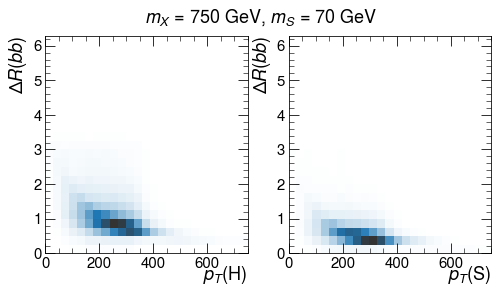

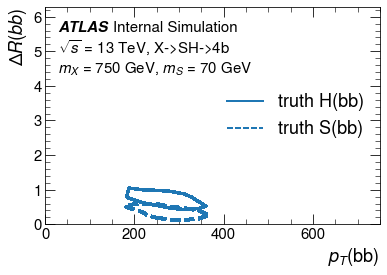

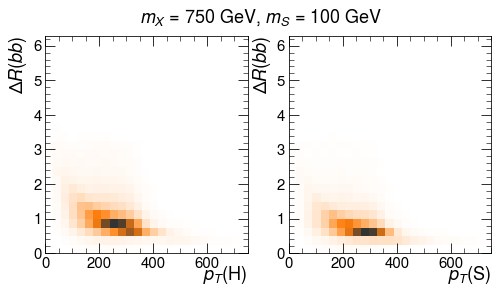

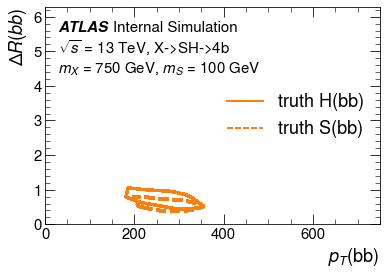

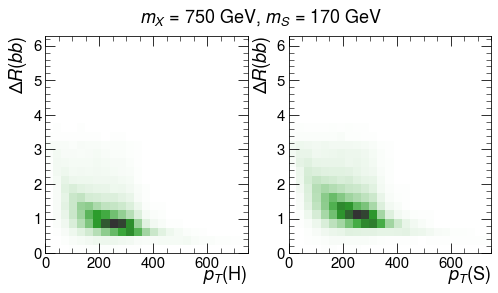

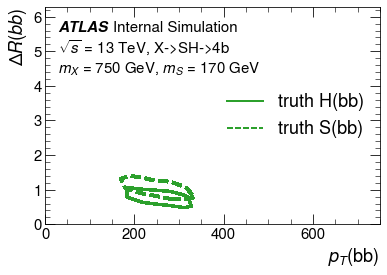

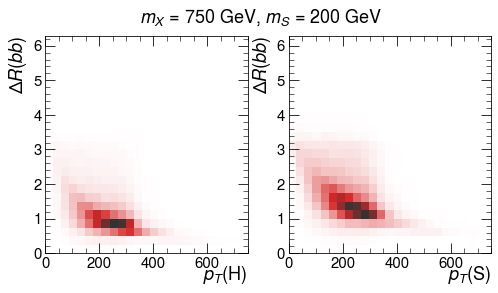

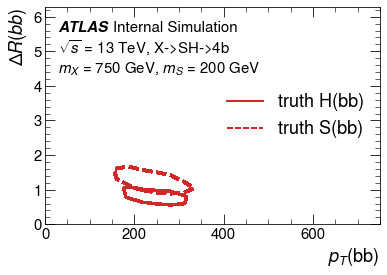

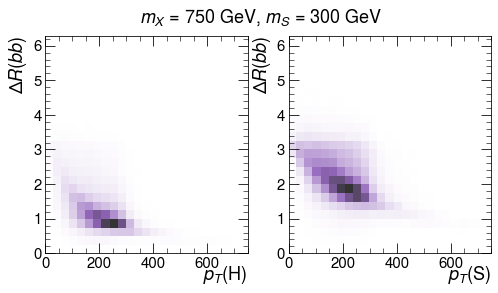

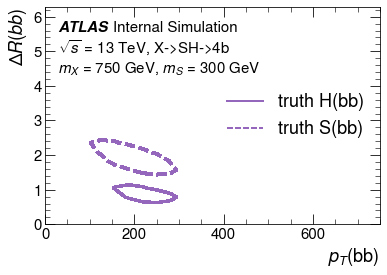

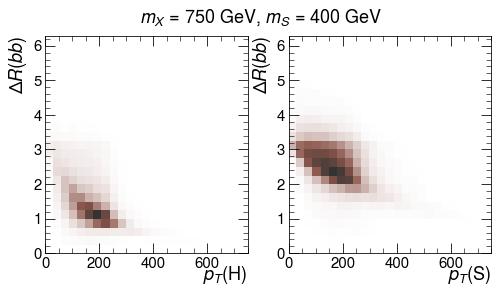

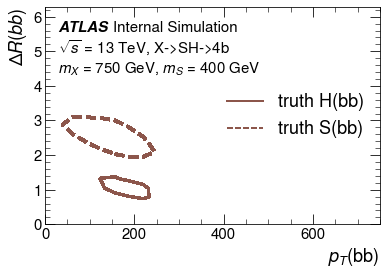

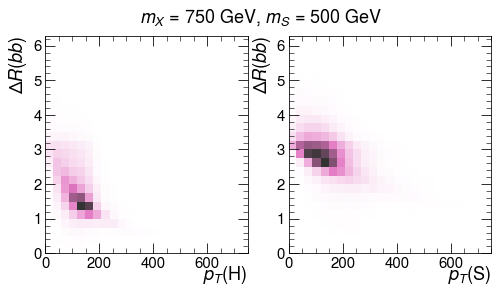

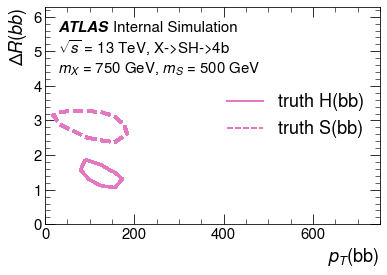

In [222]:
for i, mS, b4 in zip(range(len(mS_list)),mS_list, bs):
    
    H = b4[:,0] + b4[:,1]
    S = b4[:,2] + b4[:,3]
    
    dR_H = b4[:,0].delta_r(b4[:,1])
    dR_S = b4[:,2].delta_r(b4[:,3])
    
    # break

    fig, [ax1,ax2] = plt.subplots(1,2,figsize=(8,4))

    kwargs = {'bins':25, 'range':[(0,750), (0,2*np.pi)], 'cmap':f'C{i}'} 

    c1 = ax1.hist2d(H.pt.to_numpy(), dR_H.to_numpy(),**kwargs)[0]
    c2 = ax2.hist2d(S.pt.to_numpy(), dR_S.to_numpy(),**kwargs)[0]

    ax1.set_xlabel('$p_T$(H)',fontsize=18,x=1,ha='right',va='center')
    ax1.set_ylabel('$\Delta R(bb)$',fontsize=18,y=1,ha='right',va='bottom')

    ax2.set_xlabel('$p_T$(S)',fontsize=18,x=1,ha='right',va='center')
    ax2.set_ylabel('$\Delta R(bb)$',fontsize=18,y=1,ha='right',va='bottom')

    fig.suptitle(f'$m_X$ = {mX} GeV, $m_S$ = {mS} GeV')

    plt.savefig(f'figures/mX750/hist2d_truth_dR_vs_pt_{mS}.pdf',bbox_inches='tight')
    
    # New figure with contour lines
    plt.figure()
    fig = plt.gcf()
    ax = plt.gca()
    contour(c1.T,extent=[*kwargs['range'][0],*kwargs['range'][1]],
                  linewidths=lw,linestyles='-',colors=f'C{i}',
                  levels=[0.5*np.max(c1)])


    contour(c2.T,extent=[*kwargs['range'][0],*kwargs['range'][1]],
            linewidths=lw,linestyles='--',colors=f'C{i}',
            levels=[0.5*np.max(c2)],)

    plt.xlabel('$p_T$(bb)',fontsize=18,loc='right')
    plt.ylabel('$\Delta R(bb)$',fontsize=18,loc='top')

    pas.makeATLAStag(ax, fig, first_tag=first_tag, 
                     second_tag=second_tag+f', $m_S$ = {mS} GeV', line_spacing=1)
    
    # Add a legend
    for c,ls in zip(['H','S'],['-','--']):
        ax.plot([],[],label=f'truth {c}(bb)',ls=ls,color=f'C{i}')
    
    ax.legend(fontsize=18,loc='center right')
    plt.savefig(f'figures/mX750/truth_dR_vs_pt_{mS}.pdf',bbox_inches='tight')
    plt.show()

What have we learned?

1. Choosing the pairing that minimizes the $\Delta R$ for the leading candidate _maybe_ not the end of the world...
2. It might be better to just take the `min dR` over _all_ of the possible combinations

**Metrics to check:**
- $X_{HH}$ efficiency / signal yield
- Massplanes

OK, a preliminary $X_{SH}$ plof for **one** masspoint is in the `MAR23-prod` notebook, and I'll look at some **massplanes** here next!!

In [90]:
dfs = []

load_cols = [ 'X_wt_tag', 'mc_sf', 'truth_mhh_bs', 'm_SH', 'm_H', 'm_S', 'dEta_SH', 'X_SH', 'correct',]
# 'pt_SH', 'pt_H', 'eta_H', 'phi_H', 'pt_S', 'eta_S', 'phi_S',
# 'correctPair',  'chosenPair', 

for i,mS in enumerate(mS_list):
    fname = f'../data/X750_S{mS}_mc20e-MAR23/df_min_dR_all_4b_DL1d77_4b.parquet'
    dfs.append(pd.read_parquet(fname,columns=load_cols))
    # break

In [77]:
df = dfs[0]

In [78]:
dfs[0].columns

Index(['X_wt_tag', 'mc_sf', 'truth_mhh_bs', 'm_SH', 'm_H', 'm_S', 'dEta_SH',
       'X_SH', 'correct'],
      dtype='object')

In [79]:
from trigger import offline_mask
import operator as SmoothOperator

In [92]:
cuts = {
    "offVar": ["dEta_SH", "X_wt_tag"],
    "offVarCut": [1.5, 1.5],
    "operator": [SmoothOperator.lt, SmoothOperator.gt],
    }

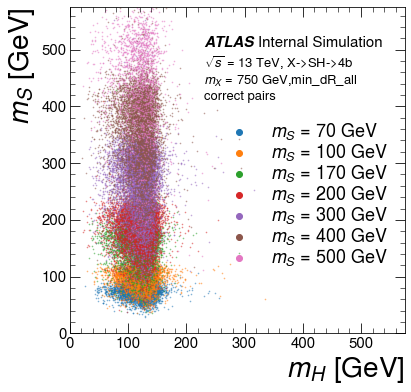

In [81]:

plt.figure(figsize=(6,6))

for i, mS, df in zip(range(len(mS_list)),mS_list,dfs):
    
    mask = offline_mask(df, cuts)
    
    plt.scatter(*df.loc[mask & df.correct,['m_H','m_S']].values.T,.4,
                color=f'C{i}',alpha=.5)
    
    # For the legend -- bigger markers
    plt.scatter([],[],color=f'C{i}',label=f'$m_S$ = {mS} GeV')
    
plt.xlabel('$m_H$ [GeV]',fontsize=28,loc='right')
plt.ylabel('$m_S$ [GeV]',fontsize=28,loc='top')

plt.legend(loc='upper right',labelspacing=0,fontsize=18,bbox_to_anchor=(1,.7))

r = (0,575)
plt.xlim(r)
plt.ylim(r)

fig = plt.gcf()
ax = plt.gca()
pas.makeATLAStag(ax, fig, first_tag=first_tag,
                 second_tag=second_tag+f',min_dR_all\ncorrect pairs', 
                 xmin=.4,line_spacing=.8,fontsize_label=13)

plt.savefig(f'figures/mX750/scatter_mH_mS_min_dR_all_correct.jpg',bbox_inches='tight')
plt.show()

This plot is pretty! But... there's also a lot of overlap between the signals :/ 

Could I propose the SR centers from here?

In [130]:
from statsmodels.stats.weightstats import DescrStatsW

In [136]:
S_mu = []
S_med= []

for i, mS, df in zip(range(len(mS_list)),mS_list,dfs):
    
    mask = offline_mask(df, cuts)
    
    # *df.loc[mask & df.correct,['m_H','m_S']].values.T
    
    v = df.loc[mask & df.correct,'m_S'].values
    w = df.loc[mask & df.correct,'mc_sf'].values
    
    weighted_stats = DescrStatsW(v, weights=w, ddof=0)

    S_mu.append(weighted_stats.mean)
    S_med.append(weighted_stats.quantile(.5).values[0])
    
mS_arr = np.array(mS_list)
S_mu = np.array(S_mu)
S_med= np.array(S_med)

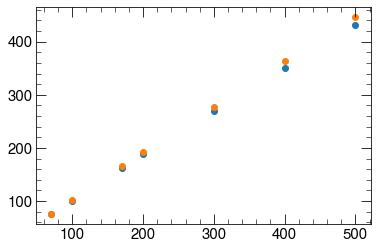

In [137]:
plt.scatter(mS_arr, S_mu)
plt.scatter(mS_arr, S_med)

In [139]:
S_mu

array([ 74.96521503,  99.36623946, 162.33311129, 188.51281009,
       269.25306531, 350.40202276, 430.32191195])

**Plan:** Make 2d histograms 
- for each SR
- for each signal (it prob will only be interesting to show the nearby signals)

In [58]:
from regions import *
from plotting import *

In [59]:
r = [0,600]
nbins=60
kwargs = {'bins':nbins, 'range':[r,r]} 

In [153]:
r_cr_x = 1.1* (125/0.84 - 125/1.16)
r_cr_x

45.15599343185552

In [157]:
mH = xi = 125
r_cr = 45
lw=1

x_cr_i = xi #*1.05

xmin_i = x_cr_i - r_cr_x
xmax_i = x_cr_i + r_cr_x

res_x = 0.1 

sr_dict = { "fn": "shiftXhh",
            "fn_args": {"center_x": xi, "center_y": None, 
                        "res_x": 0.1,"res_y":.1},
            "bound": 1.6,
            "lw": lw,
            "ls": "solid",
            "label": None,} 

In [158]:
from analysis import getXhh

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


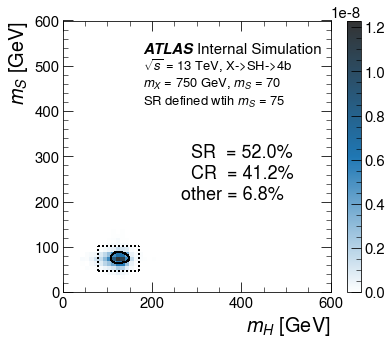

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


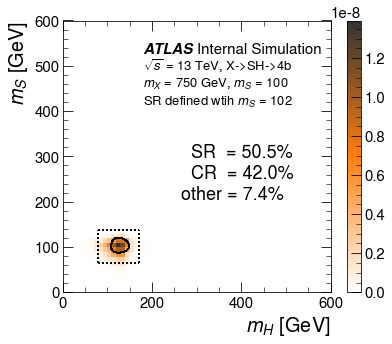

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


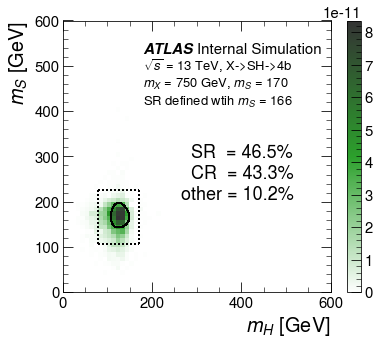

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


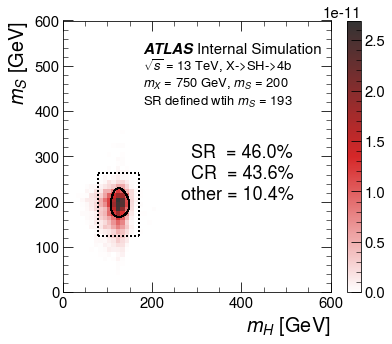

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


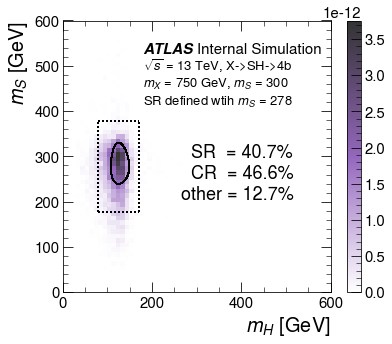

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


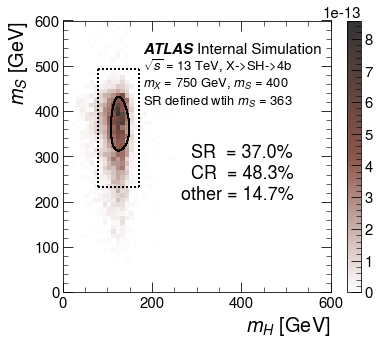

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


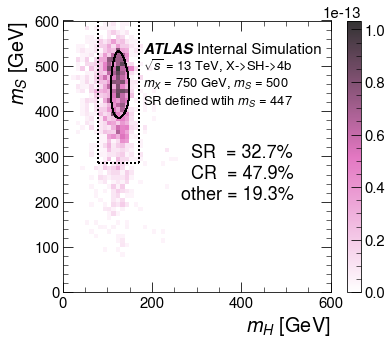

In [164]:
for i_SR, mS_SR in enumerate(S_med):
        
    # Draw the SR + bounding box consistent with the signal hypo
    yi = mS_SR

    r_cr_y =  1.1* (yi/0.84 - yi/1.16)
       
    y_cr_i = yi #*1.05
    ymin_i = y_cr_i - r_cr_y
    ymax_i = y_cr_i + r_cr_y

    sr_dict["fn_args"]["center_y"]= yi
    sr_dict['color'] = 'k' 
    
    for i_ps, (mS_ps, df) in enumerate(zip(mS_list,dfs)):
    
        if i_SR != i_ps:
            continue
    
        mask = offline_mask(df, cuts) & df.correct
     
        plt.figure(figsize=(6,5))
    
        # Need to flip if the S sig mass (rel to mH) is different from the S SR hypo
        # Also... redefine the SR based on the SR hypo :) 
        if (mS_SR - mH) * (mS_ps-mH) < 0:
            ex, ey = plt.hist2d(*df.loc[mask,['m_S','m_H']].values.T,
                       weights=df.loc[mask,'mc_sf'],
                       cmap=f'C{i_ps}',**kwargs)[1:3]
        
            df['X_SH'] = getXhh(*df[['m_S','m_H']].values.T,mH,mS_SR)
        else:
            ex, ey = plt.hist2d(*df.loc[mask,['m_H','m_S']].values.T,
                       weights=df.loc[mask,'mc_sf'],
                       cmap=f'C{i_ps}',**kwargs)[1:3]
            
            df['X_SH'] = getXhh(*df[['m_H','m_S']].values.T,mH,mS_SR)
            
        plt.colorbar()

        ax = plt.gca()
        draw_contours(ax, {'SR' : sr_dict}, ex[[0,-1]],ey[[0,-1]])
        draw_bounding_box(ax,xmin_i,xmax_i,ymin_i,ymax_i,
                          {'ls':'dotted', 'lw':1.5, 'color':'k'})

        plt.xlabel('$m_H$ [GeV]',fontsize=20,loc='right')
        plt.ylabel('$m_S$ [GeV]',fontsize=20,loc='top')

        
        fig = plt.gcf()
        ax = plt.gca()
        pas.makeATLAStag(ax, fig, first_tag=first_tag,
                         second_tag=second_tag+f', $m_S$ = {mS_ps}\nSR defined wtih $m_S$ = {mS_SR:.0f}', 
                         xmin=.3,line_spacing=.8,fontsize_label=13)
        
        # Add some text for where the signal lies in the three regions
        cuts_CR = { "offVar": ["m_H", "m_H","m_S","m_S"],
                    "offVarCut": [xmin_i,xmax_i,ymin_i,ymax_i],
                    "operator": [SmoothOperator.gt, SmoothOperator.lt]*2,
                  }
        m_SR  = (df.X_SH < 1.6)
        m_CR  = offline_mask(df,cuts_CR)
        
        ttl = np.sum(df.loc[mask,'mc_sf'])
        
        sr = np.sum(df.loc[mask & m_SR,'mc_sf'])
        cr = np.sum(df.loc[mask & m_CR & ~m_SR,'mc_sf'])
        ot = np.sum(df.loc[mask & ~m_CR,'mc_sf'])
        
        text  = f"  SR  = {sr/ttl*100:3.1f}%\n"
        text += f"  CR  = {cr/ttl*100:3.1f}%\n"
        text += f"other = {ot/ttl*100:3.1f}%\n"
        plt.text(.44,.4,text,ha='left',va='center',transform=ax.transAxes,fontsize=18)
        
        figDir = f'figures/mX{mX}/correct'
        if not os.path.exists(figDir):
            os.mkdir(figDir)
        
        plt.savefig(f'{figDir}/fmp_mX{mX}_mS{mS_ps}.jpg')
        plt.show()
        
    #     break
    # break

Now show the rest of the plots with the signal contamination too!!

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


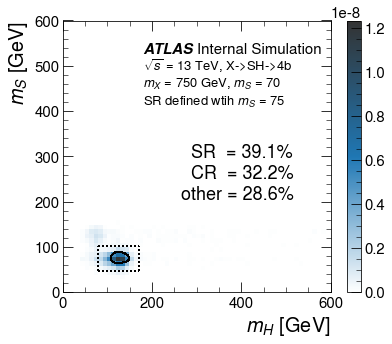

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


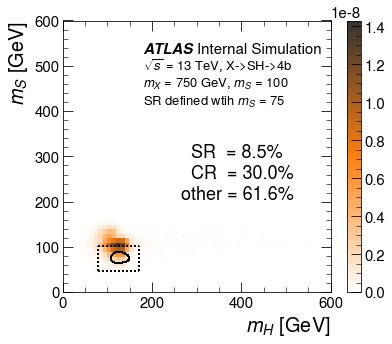

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


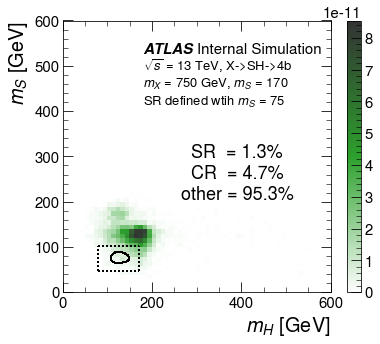

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


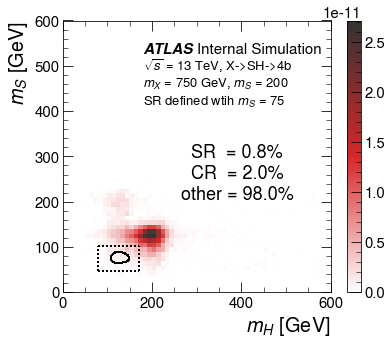

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


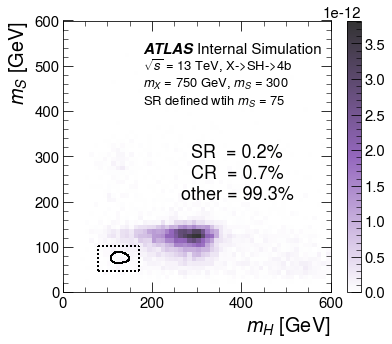

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


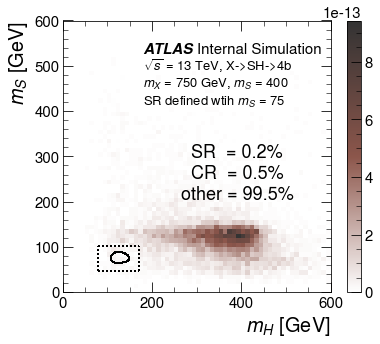

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


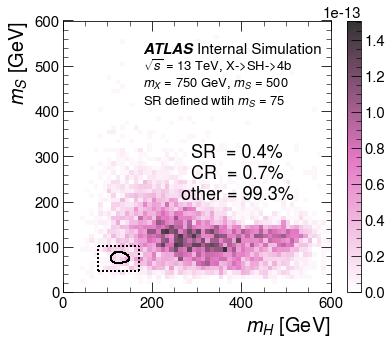

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


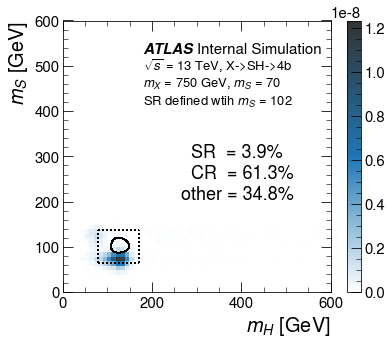

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


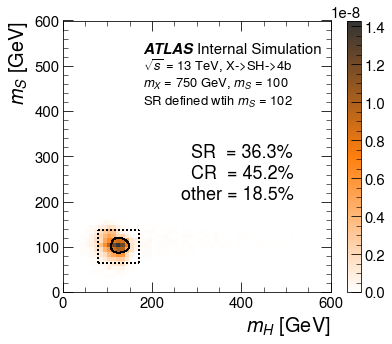

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


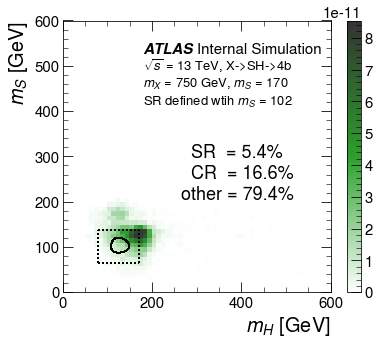

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


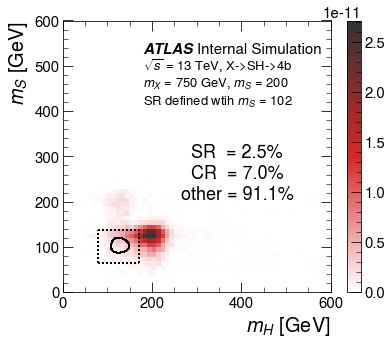

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


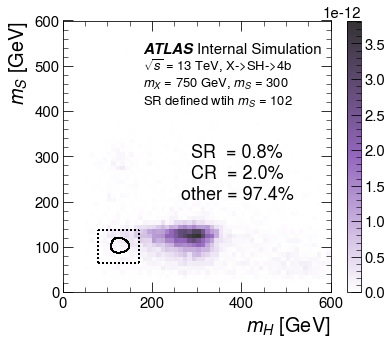

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


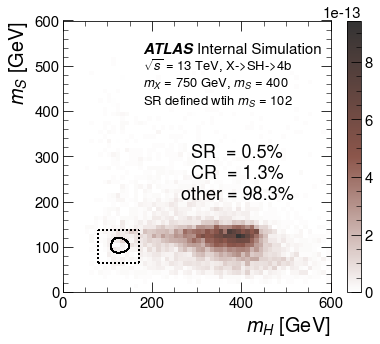

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


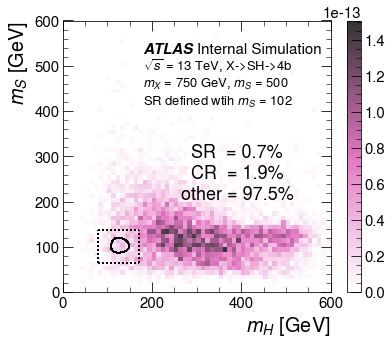

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


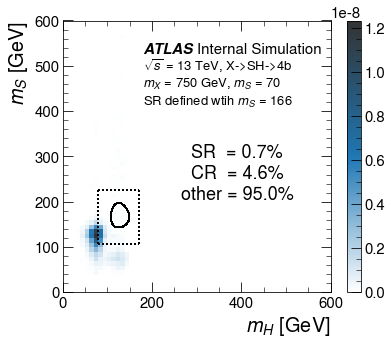

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


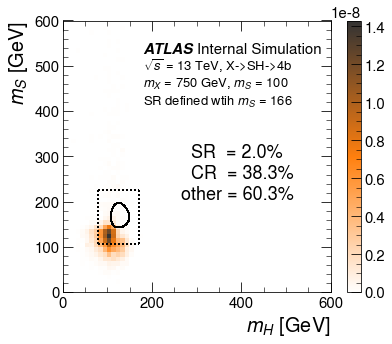

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


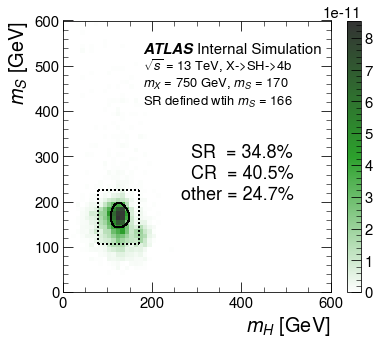

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


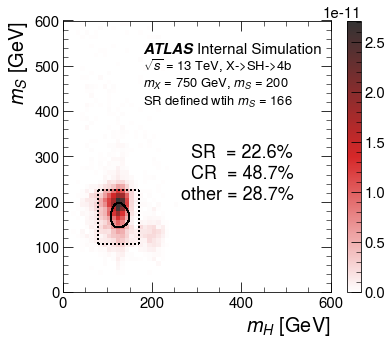

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


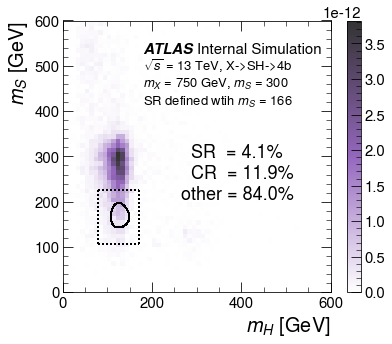

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


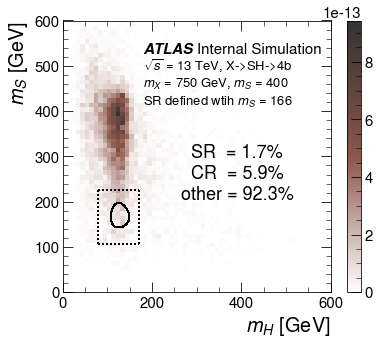

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


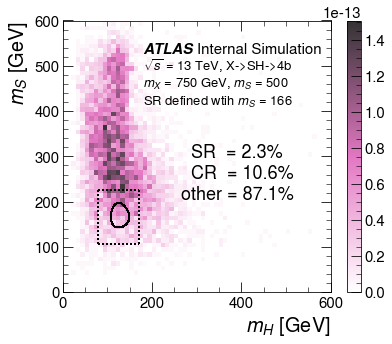

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


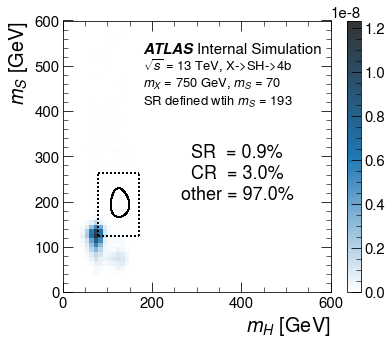

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


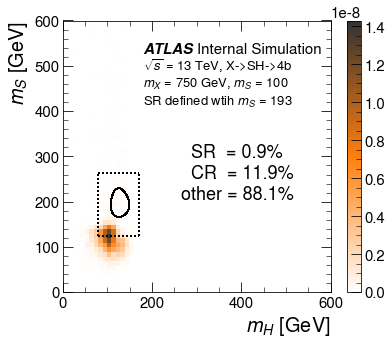

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


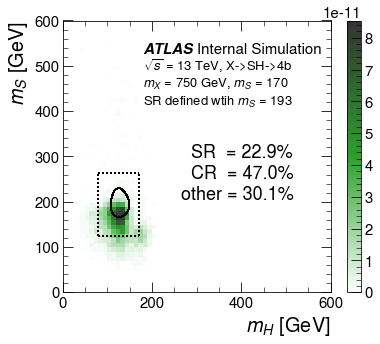

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


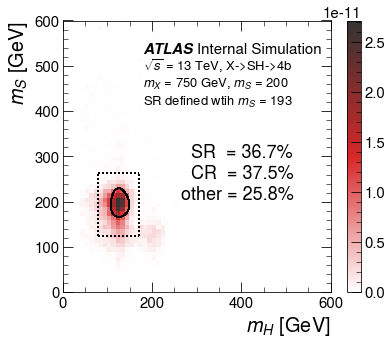

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


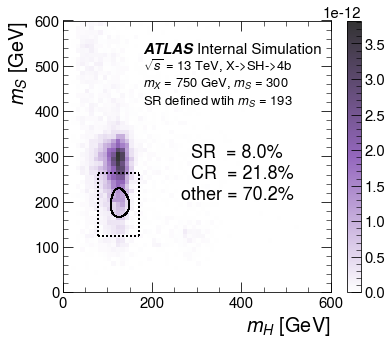

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


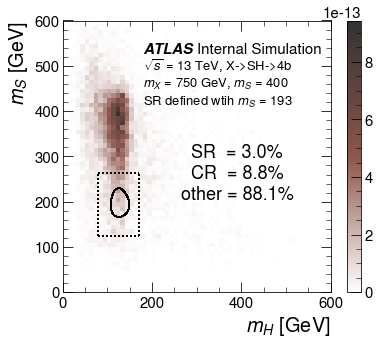

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


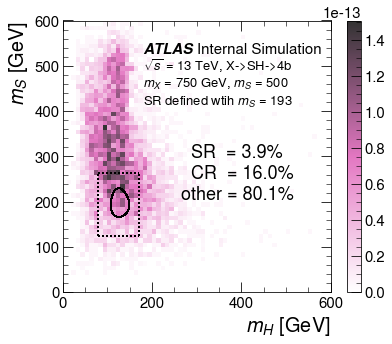

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


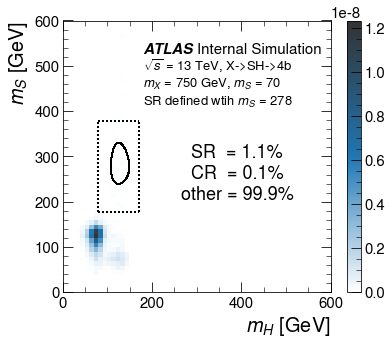

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


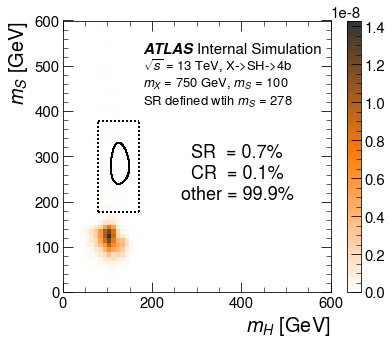

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


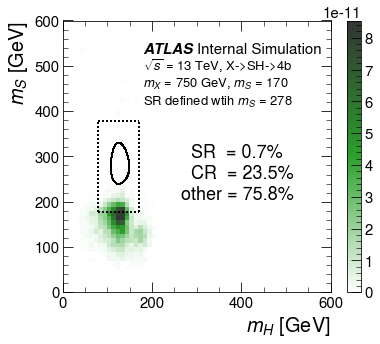

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


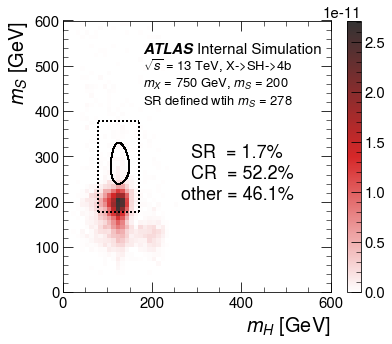

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


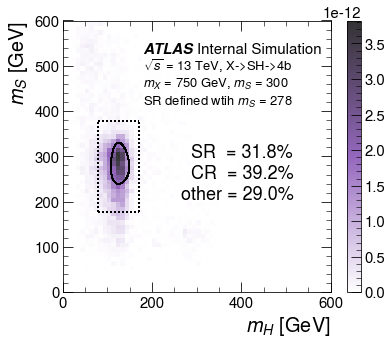

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


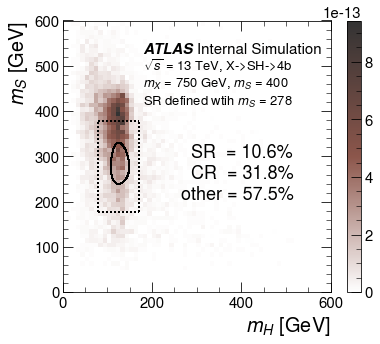

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


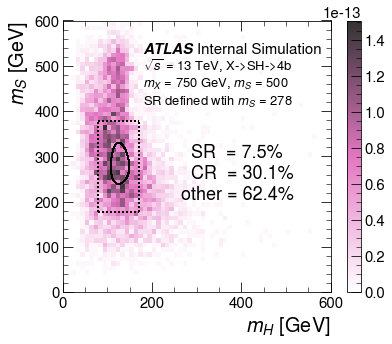

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


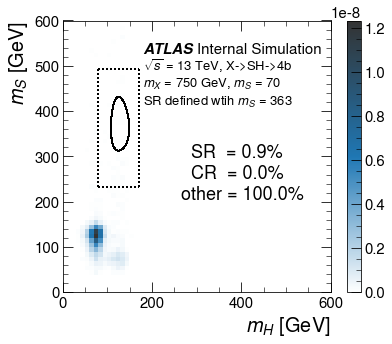

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


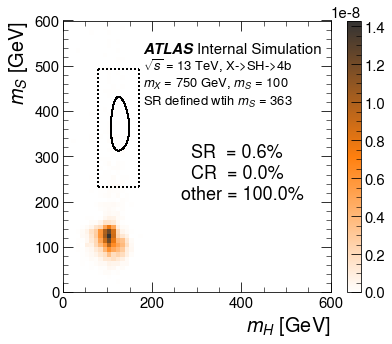

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


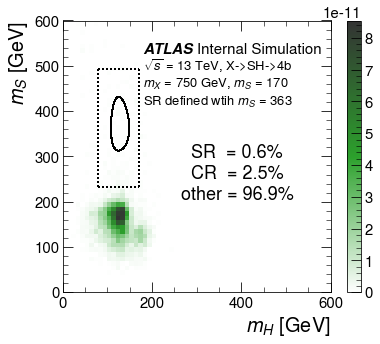

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


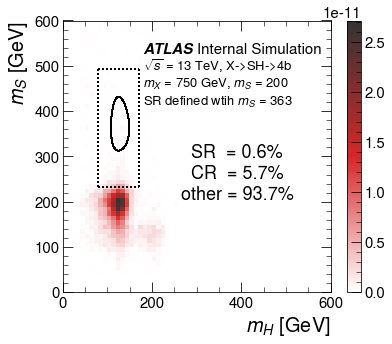

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


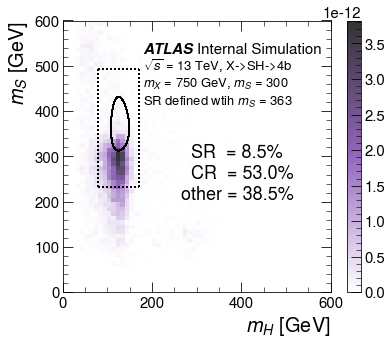

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


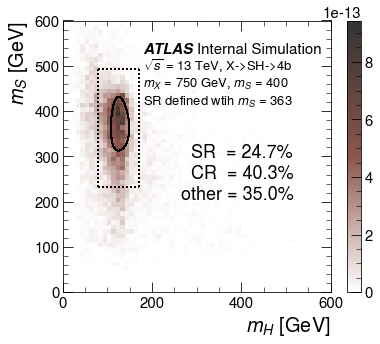

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


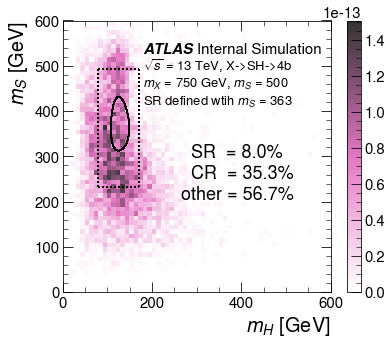

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


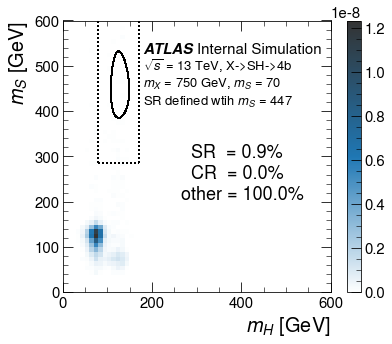

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


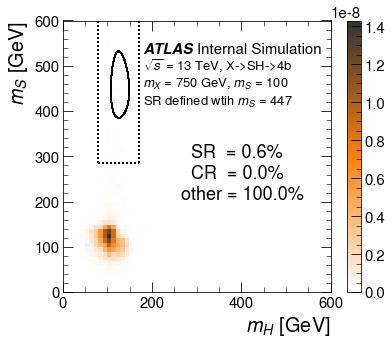

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


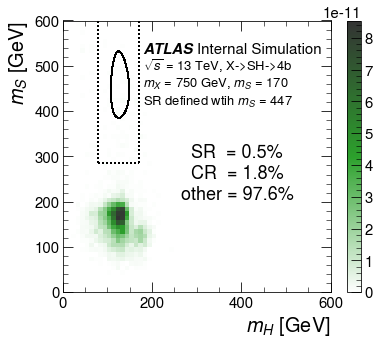

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


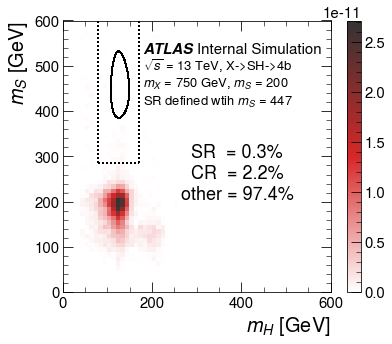

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


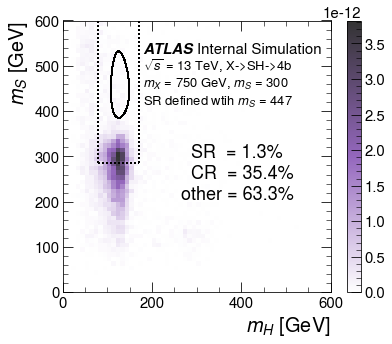

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


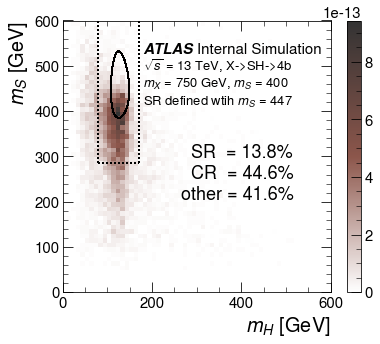

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


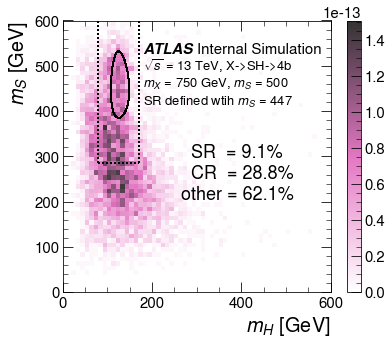

In [167]:
for i_SR, mS_SR in enumerate(S_med):
        
    # Draw the SR + bounding box consistent with the signal hypo
    yi = mS_SR

    r_cr_y =  1.1* (yi/0.84 - yi/1.16)
       
    y_cr_i = yi #*1.05
    ymin_i = y_cr_i - r_cr_y
    ymax_i = y_cr_i + r_cr_y
    res_y = 0.1 * 125 / yi

    sr_dict["fn_args"]["center_y"]= yi
    sr_dict['color'] = 'k' 
    
    for i_ps, (mS_ps, df) in enumerate(zip(mS_list,dfs)):
    
        mask = offline_mask(df, cuts) 
     
        plt.figure(figsize=(6,5))
    
        # Need to flip if the S sig mass (rel to mH) is different from the S SR hypo
        # Also... redefine the SR based on the SR hypo :) 
        if (mS_SR - mH) * (mS_ps-mH) < 0:
            ex, ey = plt.hist2d(*df.loc[mask,['m_S','m_H']].values.T,
                       weights=df.loc[mask,'mc_sf'],
                       cmap=f'C{i_ps}',**kwargs)[1:3]
        
            df['X_SH'] = getXhh(*df[['m_S','m_H']].values.T,mH,mS_SR)
        else:
            ex, ey = plt.hist2d(*df.loc[mask,['m_H','m_S']].values.T,
                       weights=df.loc[mask,'mc_sf'],
                       cmap=f'C{i_ps}',**kwargs)[1:3]
            
            df['X_SH'] = getXhh(*df[['m_H','m_S']].values.T,mH,mS_SR)
            
        plt.colorbar()

        ax = plt.gca()
        draw_contours(ax, {'SR' : sr_dict}, ex[[0,-1]],ey[[0,-1]])
        draw_bounding_box(ax,xmin_i,xmax_i,ymin_i,ymax_i,
                          {'ls':'dotted', 'lw':1.5, 'color':'k'})

        plt.xlabel('$m_H$ [GeV]',fontsize=20,loc='right')
        plt.ylabel('$m_S$ [GeV]',fontsize=20,loc='top')

        
        fig = plt.gcf()
        ax = plt.gca()
        pas.makeATLAStag(ax, fig, first_tag=first_tag,
                         second_tag=second_tag+f', $m_S$ = {mS_ps}\nSR defined wtih $m_S$ = {mS_SR:.0f}', 
                         xmin=.3,line_spacing=.8,fontsize_label=13)
        
        # Add some text for where the signal lies in the three regions
        cuts_CR = { "offVar": ["m_H", "m_H","m_S","m_S"],
                    "offVarCut": [xmin_i,xmax_i,ymin_i,ymax_i],
                    "operator": [SmoothOperator.gt, SmoothOperator.lt]*2,
                  }
        m_SR  = (df.X_SH < 1.6)
        m_CR  = offline_mask(df,cuts_CR)
        
        ttl = np.sum(df.loc[mask,'mc_sf'])
        
        sr = np.sum(df.loc[mask & m_SR,'mc_sf'])
        cr = np.sum(df.loc[mask & m_CR & ~m_SR,'mc_sf'])
        ot = np.sum(df.loc[mask & ~m_CR,'mc_sf'])
        
        text  = f"  SR  = {sr/ttl*100:3.1f}%\n"
        text += f"  CR  = {cr/ttl*100:3.1f}%\n"
        text += f"other = {ot/ttl*100:3.1f}%\n"
        plt.text(.44,.4,text,ha='left',va='center',transform=ax.transAxes,fontsize=18)
        
        figDir = f'figures/mX{mX}_mS{mS_SR:.0f}/'
        if not os.path.exists(figDir):
            os.mkdir(figDir)
        
        plt.savefig(f'{figDir}/fmp_mX{mX}_mS{mS_ps}.jpg')
        plt.show()
        
    #     break
    # break